# DETECCION DE FUEGO FORESTAL EMPLEANDO TRANSFER LEARNING

El presente notebook tiene como fin el crear un modelo de deteccion de incendios forestales.

## OBTENCION DE DATOS

Los datos que se van a emplear es un conjunto de imagenes provenientes de kaggle, de un dataset de incendios forestales.

https://www.kaggle.com/cristiancristancho/forest-fire-image-dataset

In [1]:
! mkdir ~/.kaggle

In [ ]:
 from google.colab import files
 files.upload()

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download 'cristiancristancho/forest-fire-image-dataset'

 99% 990M/995M [00:16<00:00, 64.6MB/s]
100% 995M/995M [00:16<00:00, 64.4MB/s]


In [6]:
!unzip -qq forest-fire-image-dataset.zip 

## PRE PROCESAMIENTO DE LOS DATOS

In [7]:
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import re
import math  

In [8]:
fire_path = "/content/FOREST_FIRE_DATASET/FIRE"
fire_list = os.listdir(fire_path)
print(fire_list[0:5])
len(fire_list)

['FIRE (569).jpg', 'FIRE (474).png', 'FIRE (1871).jpg', 'FIRE (574).jpg', 'FIRE (698).jpg']


2890

In [9]:
non_fire_path = "/content/FOREST_FIRE_DATASET/NON_FIRE"
non_fire_list = os.listdir(non_fire_path)
print(non_fire_list[0:5])
len(non_fire_list)

['NON_FIRE (3904).jpg', 'NON_FIRE (3244).jpg', 'NON_FIRE (2255).jpg', 'NON_FIRE (815).jpg', 'NON_FIRE (3111).jpg']


6127

### Creacion de los directorios de entrenamiento y test

In [10]:
from shutil import copyfile
import random

In [11]:
!mkdir FIRE_DATASET
!mkdir FIRE_DATASET/train
!mkdir FIRE_DATASET/validation
!mkdir FIRE_DATASET/train/0_non_fire
!mkdir FIRE_DATASET/train/1_fire
!mkdir FIRE_DATASET/validation/0_non_fire
!mkdir FIRE_DATASET/validation/1_fire

In [12]:
train_dir = 'FIRE_DATASET/train'
validation_dir = 'FIRE_DATASET/validation'

fire_train_dir = 'FIRE_DATASET/train/1_fire'
non_fire_train_dir = 'FIRE_DATASET/train/0_non_fire'

fire_valitation_dir = 'FIRE_DATASET/validation/1_fire'
non_fire_validation_dir = 'FIRE_DATASET/validation/0_non_fire'

In [13]:
train_size = 0.8

random.shuffle(fire_list)
random.shuffle(non_fire_list)

train_fire_size = int(len(fire_list)*train_size)
train_non_fire_size = int(len(non_fire_list)*train_size)



print('Datos en la categoria de fuego:' + str(len(fire_list)))
print('-'*60)
print('Datos de entrenamiento en la categoria de fuego:' + str(train_fire_size))
print('Datos de validacion en la categoria de fuego:' + str(len(fire_list)-train_fire_size))
print('*'*60)
print(' ')
print('Datos en la categoria de no_fuego:' + str(len(non_fire_list)))
print('-'*60)
print('Datos de entrenamiento en la categoria de no_fuego:' + str(train_non_fire_size))
print('Datos de validacion en la categoria de no_fuego:' + str(len(non_fire_list)-train_non_fire_size))
print('*'*60)

Datos en la categoria de fuego:2890
------------------------------------------------------------
Datos de entrenamiento en la categoria de fuego:2312
Datos de validacion en la categoria de fuego:578
************************************************************
 
Datos en la categoria de no_fuego:6127
------------------------------------------------------------
Datos de entrenamiento en la categoria de no_fuego:4901
Datos de validacion en la categoria de no_fuego:1226
************************************************************


In [14]:
for i in range(len(fire_list)):

  if i < train_fire_size:
    copyfile(fire_path + '/' + fire_list[i], fire_train_dir + '/' + fire_list[i])

  else:
    copyfile(fire_path + '/' + fire_list[i], fire_valitation_dir + '/' + fire_list[i])

In [15]:
for i in range(len(non_fire_list)):

  if i < train_non_fire_size:
    copyfile(non_fire_path + '/' + non_fire_list[i], non_fire_train_dir + '/' + non_fire_list[i])

  else:
    copyfile(non_fire_path + '/' + non_fire_list[i], non_fire_validation_dir + '/' + non_fire_list[i])

In [16]:
number_of_images = 30

plt.figure(figsize=(30,25))

for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = cv2.imread(fire_path + '/' +  fire_list[np.random.randint(train_fire_size)])
    im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)

plt.suptitle('FIRE IMAGES', fontsize=24) 
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [17]:
number_of_images = 30

plt.figure(figsize=(30,25))

for i in range(number_of_images):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    image = cv2.imread(non_fire_path + '/' +  non_fire_list[np.random.randint(train_non_fire_size)])
    im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(im_rgb)

plt.suptitle('NON FIRE IMAGES', fontsize=24) 
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# MODELO MOBILENETv3 

El modelo elegido para aplicar tranfer learning fue mobilenet v3 debido a que esta pensado para ser ejecutado en dispositivos con bajos recursos ademas de ser muy liviano en caso tal de querer aplicar fine tuning.

###Data generators para hacer aumentacion de datos

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [37]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (244, 244))    

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 64,
                                                          class_mode  = 'binary', 
                                                          target_size = (224, 244))

Found 7211 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.


In [38]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 244, 244, 3), (64,))

In [39]:
print (train_generator.class_indices)

{'0_non_fire': 0, '1_fire': 1}


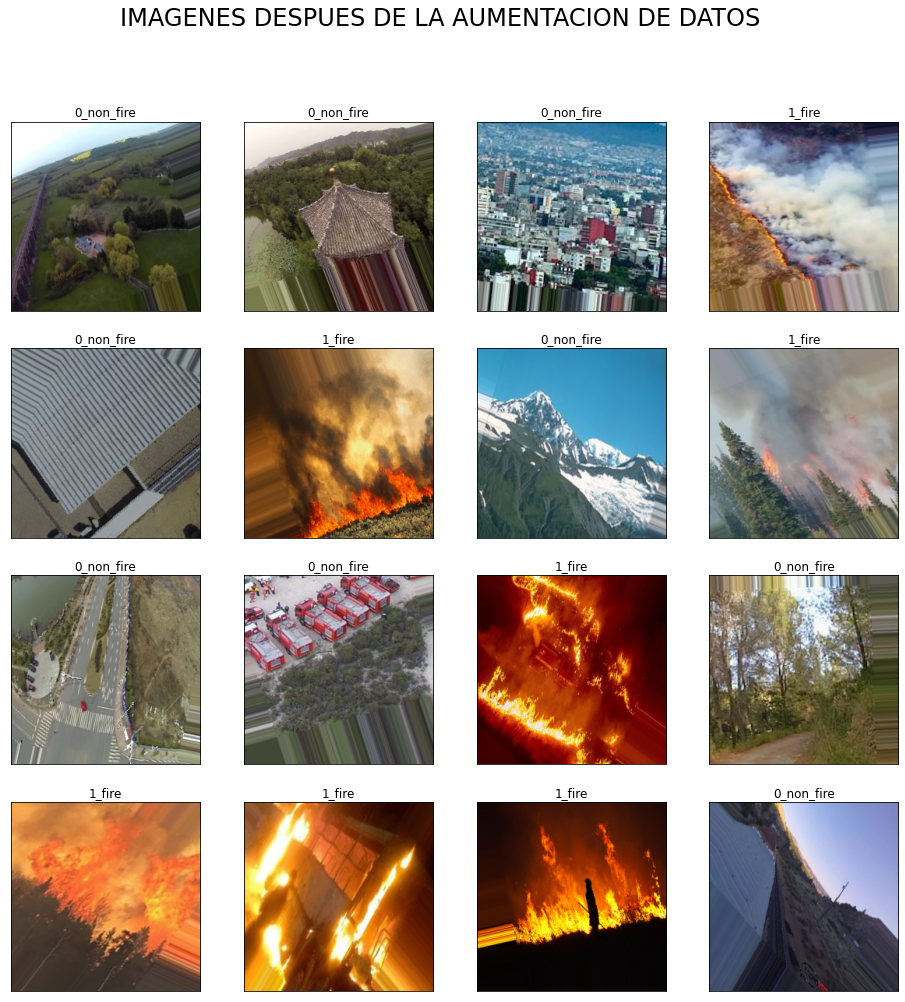

In [40]:
number_of_images = 16

plt.figure(figsize=(16,16))

for i in range(number_of_images):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image_batch[i])
    plt.title(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(label_batch[i])])

plt.suptitle('IMAGENES DESPUES DE LA AUMENTACION DE DATOS', fontsize=24) 
plt.show()

In [62]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose,UpSampling2D, Flatten, Reshape, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.utils import plot_model

In [24]:
from tensorflow.keras.applications import MobileNetV3Large

###Importacion del modelo base MobileNet v3

In [25]:
IMG_SHAPE = (224,224,3)
base_model = MobileNetV3Large(input_shape=IMG_SHAPE,
                              include_top=False, 
                              weights='imagenet')

base_model.trainable = False

17612800/17605208 [==============================] - 0s 0us/step


### Añadimos nuestras capas extra

In [80]:
x = base_model.output
x = Conv2D(128, kernel_size=(3,3))(x)
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
preds=Dense(1,activation='sigmoid')(x) 

In [81]:
model=Model(inputs=base_model.input,outputs=preds)

In [ ]:
model.summary()

### Callbacks

In [83]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'mobilenetv3_Fire.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=3,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

### Compilacion

In [84]:
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

In [85]:
METRICS = [ 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall')
      ]

model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=METRICS)

### Pesos a las clases

In [86]:
total = len(fire_list) + len(non_fire_list)

weight_for_0 = (1 / len(non_fire_list)) * (total / 2.0)
weight_for_1 = (1 / len(fire_list)) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.74
Weight for class 1: 1.56


### Entrenamiento

In [87]:
epochs = 32

history = model.fit(train_generator,
                validation_data=validation_generator,
                epochs=epochs,
                callbacks=callbacks,
                class_weight=class_weight)

Epoch 1/32
 30/113 [======>.......................] - ETA: 1:36 - loss: 1.0834 - accuracy: 0.4906 - precision: 0.3069 - recall: 0.4942

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


113/113 [==============================] - 175s 1s/step - loss: 0.8695 - accuracy: 0.4942 - precision: 0.3174 - recall: 0.5030 - val_loss: 0.6918 - val_accuracy: 0.5022 - val_precision: 0.3740 - val_recall: 0.8218

Epoch 00001: val_loss improved from inf to 0.69183, saving model to /content/saved_models/mobilenetv3_Fire.001.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/32
113/113 [==============================] - 147s 1s/step - loss: 0.7531 - accuracy: 0.5145 - precision: 0.3346 - recall: 0.5216 - val_loss: 0.6275 - val_accuracy: 0.6768 - val_precision: 0.4928 - val_recall: 0.2941

Epoch 00002: val_loss improved from 0.69183 to 0.62754, saving model to /content/saved_models/mobilenetv3_Fire.002.h5
Epoch 3/32
113/113 [==============================] - 146s 1s/step - loss: 0.7266 - accuracy: 0.5422 - precision: 0.3607 - recall: 0.5554 - val_loss: 0.5921 - val_accuracy: 0.6946 - val_precision: 0.6116 - val_recall: 0.1280

Epoch 00003: val_loss improved from 0.62754 to 0.59213, saving model to /content/saved_models/mobilenetv3_Fire.003.h5
Epoch 4/32
113/113 [==============================] - 147s 1s/step - loss: 0.6962 - accuracy: 0.5580 - precision: 0.3779 - recall: 0.5874 - val_loss: 0.6609 - val_accuracy: 0.6802 - val_precision: 1.0000 - val_recall: 0.0017

Epoch 00004: val_loss did not improve from 0.59213
Epoch 5/32
113/113 [===============

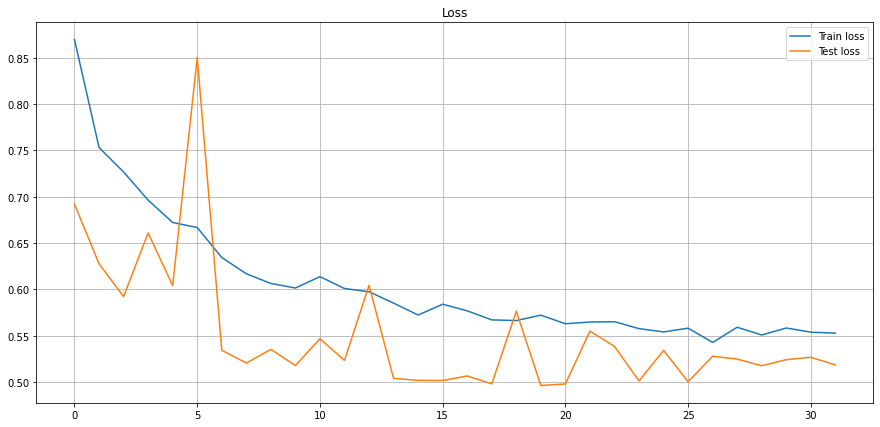

In [97]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Test loss')
plt.title('Loss')
plt.legend()
plt.grid()
plt.show()

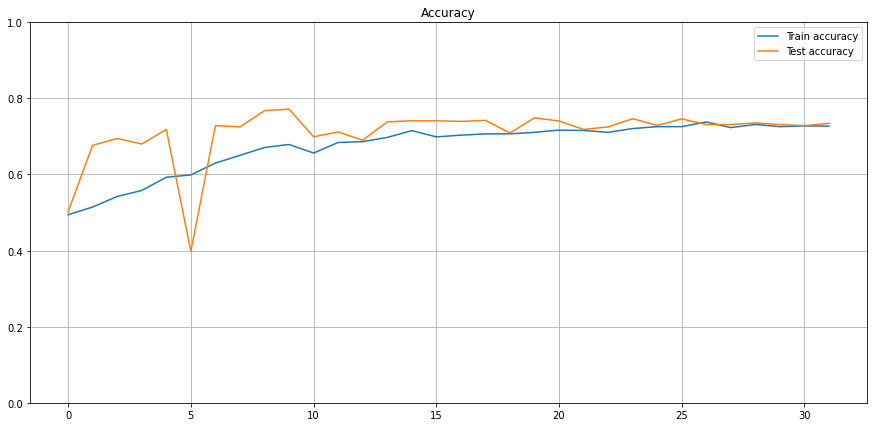

In [99]:
plt.figure(figsize=(15,7))
plt.plot(history.history['accuracy'],label='Train accuracy')
plt.plot(history.history['val_accuracy'],label='Test accuracy')
plt.ylim((0, 1))
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

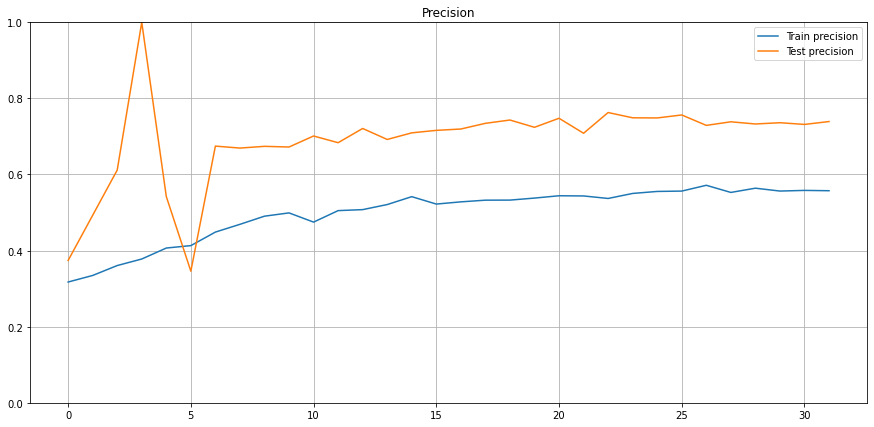

In [101]:
plt.figure(figsize=(15,7))
plt.plot(history.history['precision'],label='Train precision')
plt.plot(history.history['val_precision'],label='Test precision')
plt.ylim((0, 1))
plt.title('Precision')
plt.legend()
plt.grid()
plt.show()

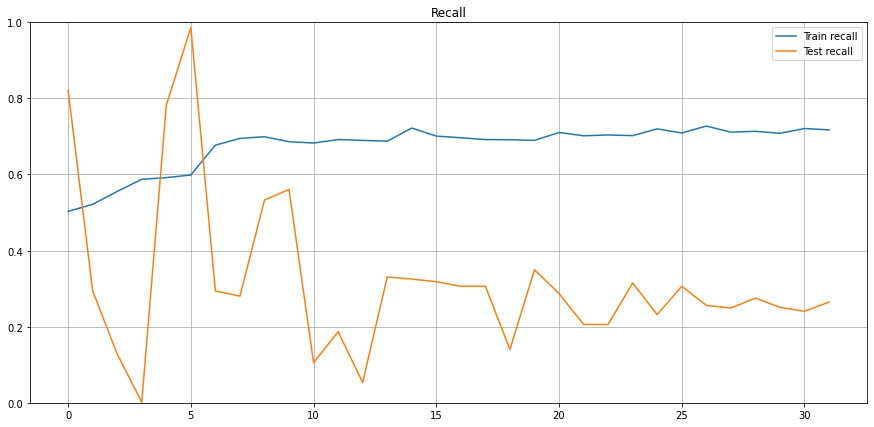

In [102]:
plt.figure(figsize=(15,7))
plt.plot(history.history['recall'],label='Train recall')
plt.plot(history.history['val_recall'],label='Test recall')
plt.ylim((0, 1))
plt.title('Recall')
plt.legend()
plt.grid()
plt.show()

# InceptionV3

###Data generators para hacer aumentacion de datos

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 64,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))    

validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 64,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 7211 images belonging to 2 classes.
Found 1804 images belonging to 2 classes.


In [51]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 150, 150, 3), (64,))

In [52]:
print (train_generator.class_indices)

{'0_non_fire': 0, '1_fire': 1}


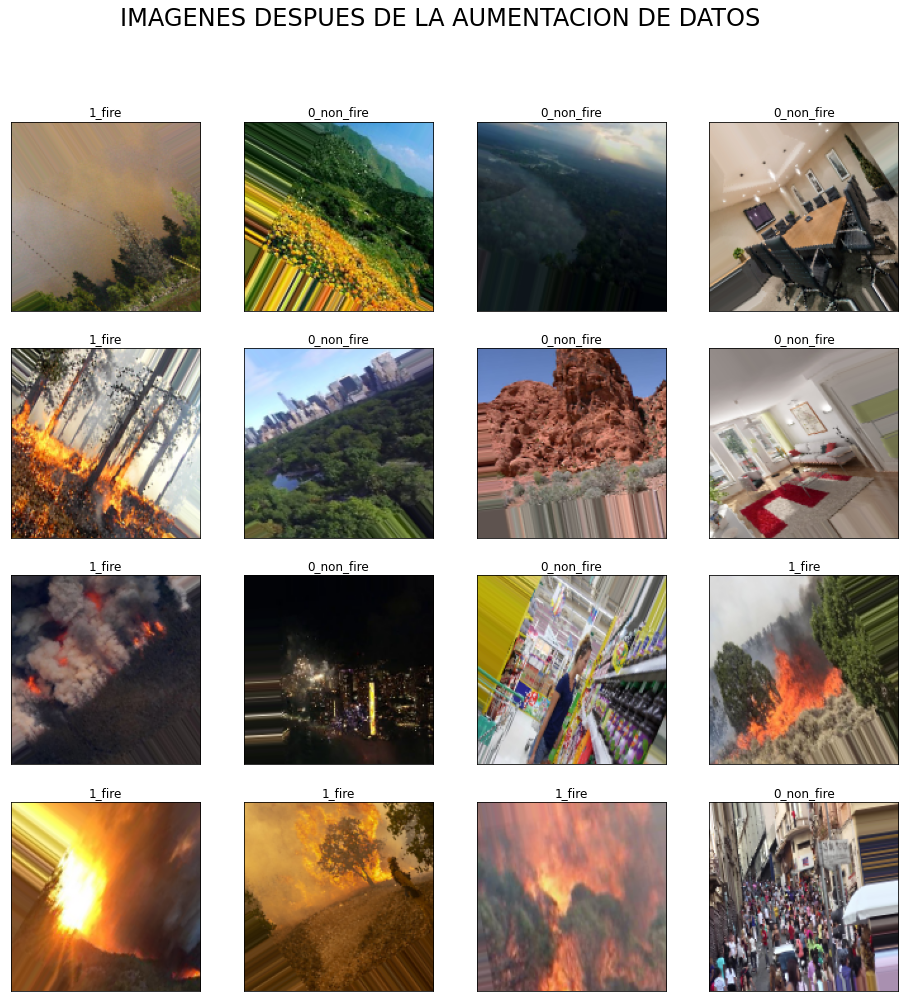

In [53]:
number_of_images = 16

plt.figure(figsize=(16,16))

for i in range(number_of_images):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(image_batch[i])
    plt.title(list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(label_batch[i])])

plt.suptitle('IMAGENES DESPUES DE LA AUMENTACION DE DATOS', fontsize=24) 
plt.show()

In [54]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose,UpSampling2D, Flatten, Reshape, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.utils import plot_model

In [55]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

###Importacion del modelo base Inception v3

In [33]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-05-26 01:16:57--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  78.9MB/s    in 1.1s    

2021-05-26 01:16:58 (78.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [56]:
IMG_SHAPE = (150,150,3)
base_model = InceptionV3(input_shape=IMG_SHAPE,
                          include_top=False, 
                          weights=None)

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model.load_weights(local_weights_file)

base_model.trainable = False

### Añadimos nuestras capas extra

In [57]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
preds=Dense(1,activation='sigmoid')(x) 

In [58]:
model=Model(inputs=base_model.input,outputs=preds)

In [59]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
____________________________________________________________________________________________

### Callbacks

In [60]:
# prepare model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'inceptionv3_Fire.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# reduce learning rate by sqrt(0.1) if the loss does not improve in 5 epochs
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=3,
                               verbose=1,
                               min_lr=0.5e-6)

# save weights for future use (e.g. reload parameters w/o training)
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)


# called every epoch
callbacks = [lr_reducer, checkpoint]

### Compilacion

In [61]:
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

In [62]:
METRICS = [ 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall')
      ]

model.compile(
      optimizer='adam',
      loss='binary_crossentropy',
      metrics=METRICS)

### Pesos a las clases

In [63]:
total = len(fire_list) + len(non_fire_list)

weight_for_0 = (1 / len(non_fire_list)) * (total / 2.0)
weight_for_1 = (1 / len(fire_list)) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.74
Weight for class 1: 1.56


###Entrenamiento

In [64]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [65]:
epochs = 32

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=epochs,
                    callbacks=callbacks,
                    class_weight=class_weight)

Epoch 1/32
 98/113 [=========================>....] - ETA: 10s - loss: 0.9361 - accuracy: 0.9024 - precision: 0.8167 - recall: 0.8994

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


113/113 [==============================] - 112s 877ms/step - loss: 0.8334 - accuracy: 0.9076 - precision: 0.8249 - recall: 0.9035 - val_loss: 0.1819 - val_accuracy: 0.9534 - val_precision: 0.9229 - val_recall: 0.9325

Epoch 00001: val_loss improved from inf to 0.18187, saving model to /content/saved_models/inceptionv3_Fire.001.h5
Epoch 2/32
113/113 [==============================] - 97s 857ms/step - loss: 0.1743 - accuracy: 0.9401 - precision: 0.8893 - recall: 0.9286 - val_loss: 0.1355 - val_accuracy: 0.9601 - val_precision: 0.9550 - val_recall: 0.9187

Epoch 00002: val_loss improved from 0.18187 to 0.13551, saving model to /content/saved_models/inceptionv3_Fire.002.h5
Epoch 3/32
113/113 [==============================] - 97s 861ms/step - loss: 0.1418 - accuracy: 0.9506 - precision: 0.9057 - recall: 0.9442 - val_loss: 0.1406 - val_accuracy: 0.9579 - val_precision: 0.9101 - val_recall: 0.9637

Epoch 00003: val_loss did not improve from 0.13551
Epoch 4/32
113/113 [=======================

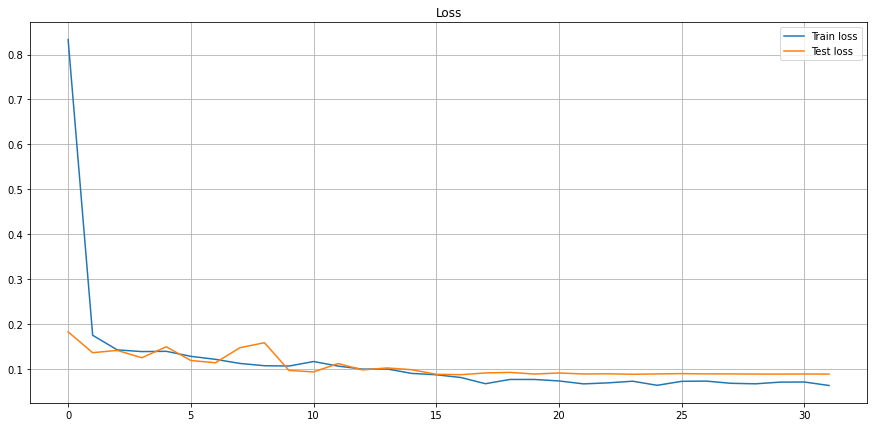

In [66]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Test loss')
plt.title('Loss')
plt.legend()
plt.grid()
plt.show()

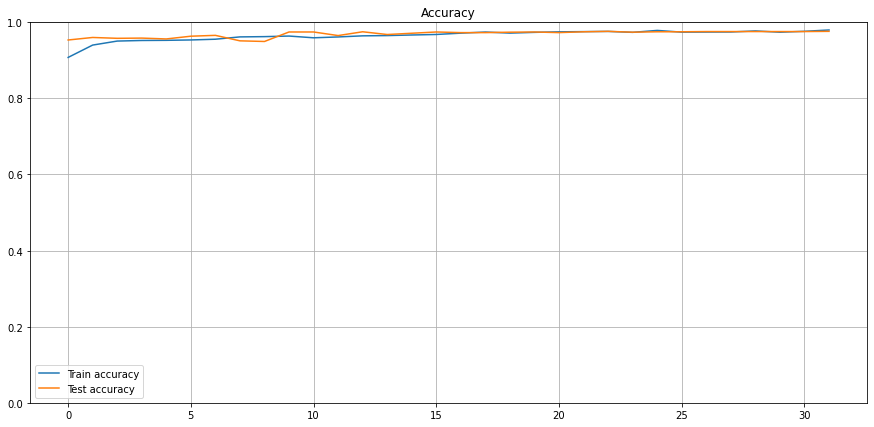

In [67]:
plt.figure(figsize=(15,7))
plt.plot(history.history['accuracy'],label='Train accuracy')
plt.plot(history.history['val_accuracy'],label='Test accuracy')
plt.ylim((0, 1))
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

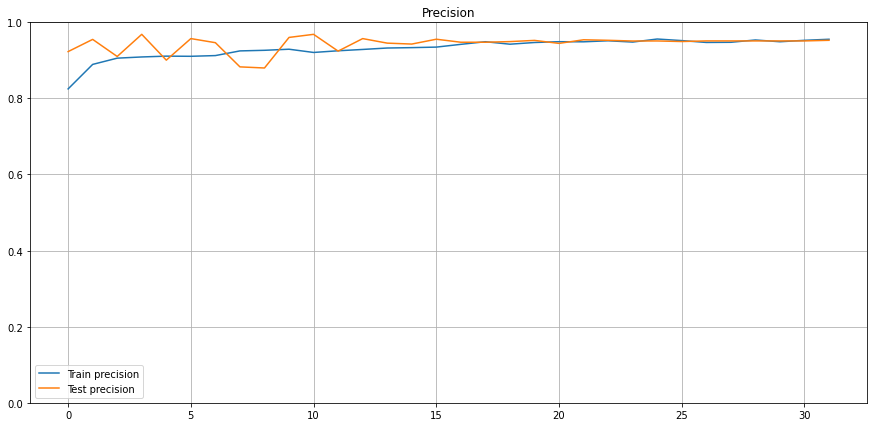

In [68]:
plt.figure(figsize=(15,7))
plt.plot(history.history['precision'],label='Train precision')
plt.plot(history.history['val_precision'],label='Test precision')
plt.ylim((0, 1))
plt.title('Precision')
plt.legend()
plt.grid()
plt.show()

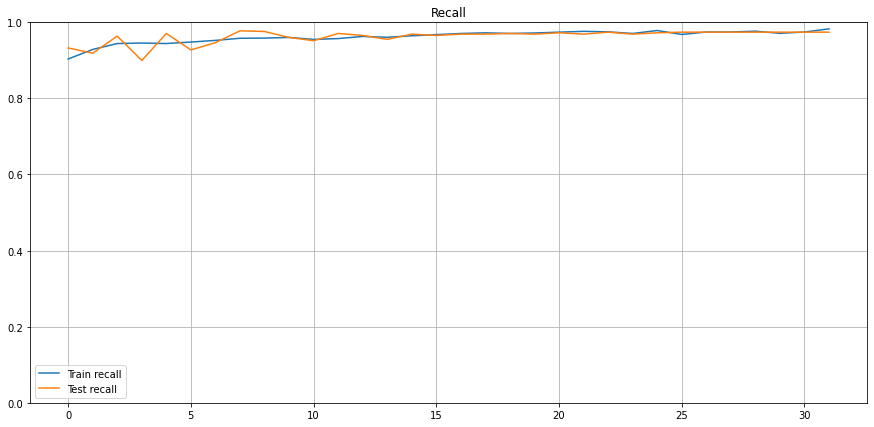

In [69]:
plt.figure(figsize=(15,7))
plt.plot(history.history['recall'],label='Train recall')
plt.plot(history.history['val_recall'],label='Test recall')
plt.ylim((0, 1))
plt.title('Recall')
plt.legend()
plt.grid()
plt.show()

### InceptionV3 > MobilenetV3

Siguientes pasos, poder correr el modelo desde un dispositivo tal como una raspberry o una jetson nano.